In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.cm as cm
import os
from glob import glob
import json
from matplotlib.lines import Line2D

matplotlib.rc_file('../minigraphs_rc')

In [3]:
DATA_DIR = '/mnt/home/martjor/repos/dev_pt/data'
def graph_data(graph_name,size,idx):
    # Load original metrics
    file_name_metrics = os.path.join(DATA_DIR,'networks',graph_name,'metrics.json')
    with open(file_name_metrics,'r') as file:
        graph_metrics = json.load(file)
        
    # Load new metrics and miniature trajectories
    dir_miniatures = os.path.join(DATA_DIR,'miniatures',graph_name,str(size))
    miniatures = os.listdir(dir_miniatures)
    miniatures.sort()
    
    root = os.path.join(dir_miniatures,miniatures[idx])
    file_name_metrics = os.path.join(root,'metrics_mini.json')
    with open(file_name_metrics,'r') as file:
        miniature_metrics = json.load(file)
    
    file_names = glob("*.parquet",root_dir=root)
    
    trajectories = [pd.read_parquet(os.path.join(root,file_name)) for file_name in file_names]
    
    print(graph_metrics,miniature_metrics,trajectories,sep='\n')
        
    return graph_metrics, miniature_metrics, trajectories

def process_trajectories(dfs,metrics_og):
    # Concatenate dataframes
    df = pd.concat(dfs,keys=np.arange(6))
    df.reset_index(inplace=True,names=['Replica','Step'])

    # Calculate errors
    for key in ['density','assortativity_norm','clustering']:
        df['err_' + key] = np.abs(df[key] - metrics_og[key])/metrics_og[key] * 100
    
    return df


metrics_og, metrics_mini, trajectories = graph_data('soc-pages-tvshow',1000,0)
df = process_trajectories(trajectories, metrics_og)

{'Graph Name': 'soc-pages-tvshow', 'num_vertices': 3900, 'num_edges': 17200, 'density': 0.00227, 'clustering': 0.37, 'assortativity': 0.56, 'assortativity_norm': 0.78}
{'Beta': 1006.6698193791967, 'Energy': 0.8992234174585599, 'density': 0.00227027027027027, 'assortativity_norm': 0.7781380188284385, 'clustering': 0.04200000000000001}
[           Beta    Energy   density  assortativity_norm  clustering
0    575.239897  2.974985  0.002939            0.480243    0.003481
1    575.239897  2.974985  0.002939            0.480243    0.003481
2    575.239897  2.974985  0.002939            0.480243    0.003481
3    575.239897  2.974985  0.002939            0.480243    0.003481
4    575.239897  2.974985  0.002939            0.480243    0.003481
..          ...       ...       ...                 ...         ...
995  575.239897  0.983574  0.002270            0.779803    0.008825
996  575.239897  0.983574  0.002270            0.779803    0.008825
997  575.239897  0.983574  0.002270            0.77

/tmp/ipykernel_2281861/4007094676.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('summer',len(replicas))
/tmp/ipykernel_2281861/4007094676.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap('Set1',len(replicas))


Text(0, 0.5, '$\\beta$')

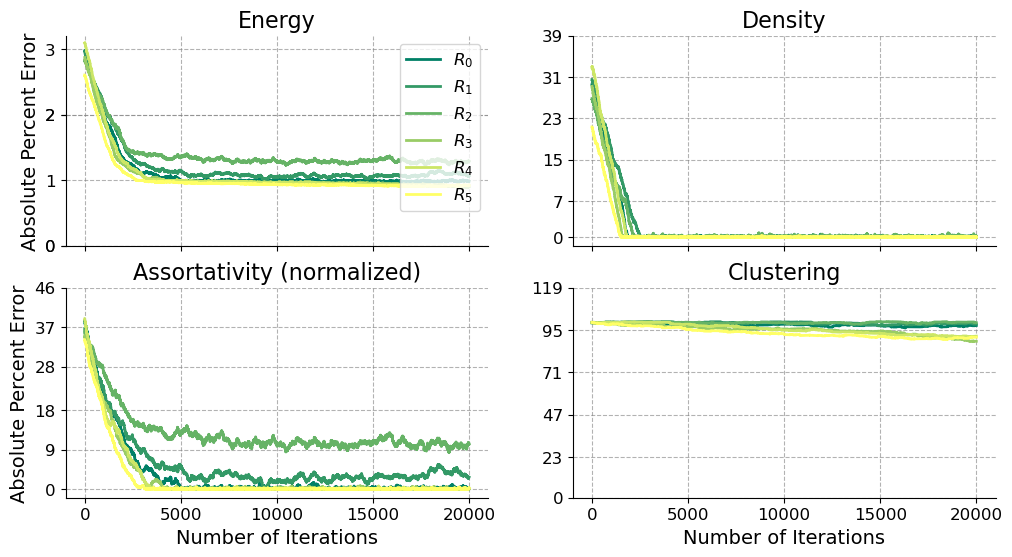

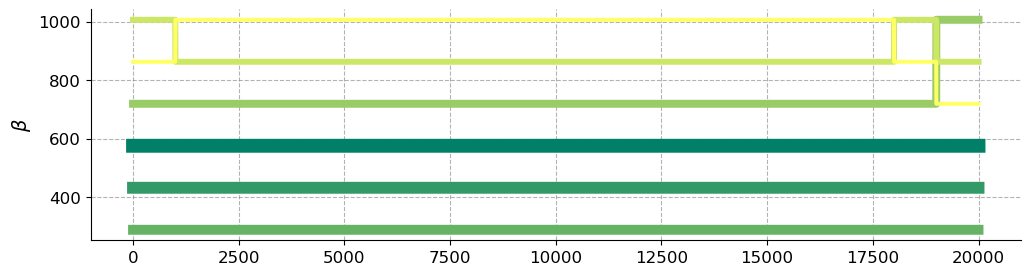

In [24]:
fig_metrics, axes = plt.subplots(2,2,figsize=(12,6))
fig_replicas, ax_replica = plt.subplots(figsize=(12,3))

# Collect replicas
replicas = df['Replica'].unique()
cmap = cm.get_cmap('summer',len(replicas))
cmap2 = cm.get_cmap('Set1',len(replicas))

for replica in replicas:
    color = cmap(replica)
    idx = df['Replica'] == replica
    get_y = lambda metric : df.loc[idx,metric]
    
    # Energy plot
    y = get_y('Energy')
    x = np.arange(y.count())
    axes[0,0].plot(x,y,color=color,label=rf"$R_{replica}$")
    axes[0,0].set_xticklabels([])
    axes[0,0].set_title("Energy")
    axes[0,0].legend()
    
    # Density plot
    y = get_y('err_density')
    axes[0,1].plot(x,y,color=color)
    axes[0,1].set_xticklabels([])
    axes[0,1].set_title('Density')
    
    # Assortativity plot#
    y = get_y('err_assortativity_norm')
    axes[1,0].plot(x,y,color=color)
    axes[1,0].set_xlabel("Number of Iterations")
    axes[1,0].set_title('Assortativity (normalized)')
    
    # Clustering plot
    y = get_y('err_clustering')
    axes[1,1].plot(x,y,color=color)
    axes[1,1].set_xlabel("Number of Iterations")
    axes[1,1].set_title('Clustering')
    
    # Replica exchange
    y = get_y('Beta')
    ax_replica.plot(x,y,linewidth=10.0*(1-replica/(len(replicas)+1)),color=cmap(replica))

maxes = df.max()
vec = np.linspace(0,1.2,6)
axes[0][0].set_yticks((vec * maxes['Energy']).astype(int))
axes[0][0].set_ylabel("Absolute Percent Error")
axes[0][0].legend(loc='upper right')
axes[0][1].set_yticks((vec * maxes['err_density']).astype(int))
axes[1][0].set_yticks((vec * maxes['err_assortativity_norm']).astype(int))
axes[1][0].set_ylabel("Absolute Percent Error")
axes[1][1].set_yticks((vec * maxes['err_clustering']).astype(int))

ax_replica.set_ylabel(r"$\beta$")


In [5]:
# Load original network datasets
def load(DIR):
    dfs = [pd.DataFrame(np.load(os.path.join(DIR,file))) for file in os.listdir(DIR)]
    df = pd.concat(dfs,keys=np.arange(len(dfs)))
    return df
    
original_sir_dir = '/mnt/home/martjor/repos/dev_pt/data/simulations/soc-pages-tvshow/original/test_01'
original_sir_df = load(original_sir_dir)
original_sir_df.rename(columns={0:'S',1:'I',2:'R'},inplace=True)

mini_sir_dir = '/mnt/home/martjor/repos/dev_pt/data/simulations/soc-pages-tvshow/1000/test_00/sir' 
mini_sir_df = load(mini_sir_dir)
mini_sir_df.rename(columns={0:'S',1:'I',2:'R'},inplace=True)
#mini_sir_df.loc[:,['S','I','R']] = mini_sir_df.loc[:,['S','I','R']] / alpha

original_dg_dir = '/mnt/home/martjor/repos/dev_pt/data/simulations/soc-pages-tvshow/original/degroot/test_00'
original_dg_df = load(original_dg_dir)

mini_dg_dir = '/mnt/home/martjor/repos/dev_pt/data/simulations/soc-pages-tvshow/1000/test_00/degroot/'
mini_dg_df = load(mini_dg_dir)

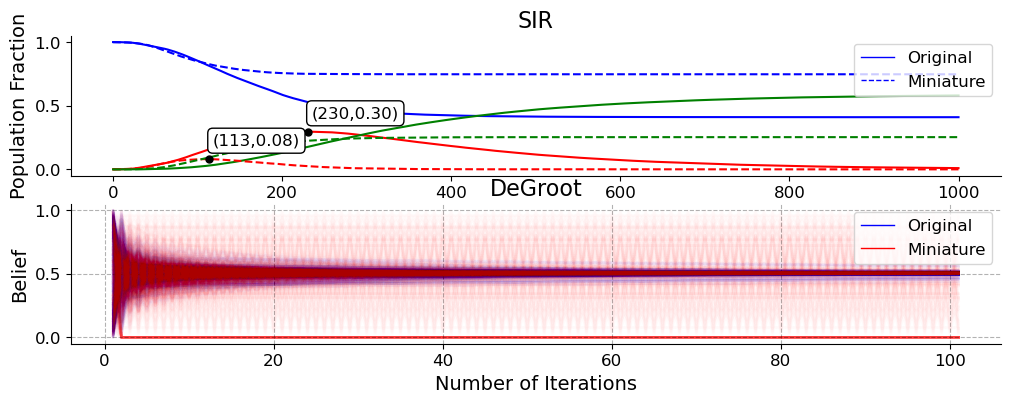

In [22]:
colors = ['b','r','g']
def plot_mean(df,ax,linestyle='-'):
    df_local = df.reset_index(names=['Run','Step'])
    group = df_local.groupby('Step').mean()
    
    for i,population in enumerate(['S','I','R']):
        ax.plot(group[population],color=colors[i],linewidth=1.5,linestyle=linestyle)
        
    # Highlight max
    y_max = group.max()['I']
    x_peak = group.idxmax()['I']
    
    ax.plot(x_peak,y_max,'ok',markersize=5)
    ax.annotate(f"({x_peak},{y_max:.2f})",
                xy=(x_peak,y_max), xycoords='data',
                xytext=(3,10), textcoords='offset points',
                bbox=dict(boxstyle='round',fc='w'))
    
    
        

def plot_trajectories(df,ax):
    indices = df.index.get_level_values(0).unique()
    
    for idx in indices:
        ax.plot(df.loc[idx]['S'],alpha=0.2,color='b')
        ax.plot(df.loc[idx]['I'],alpha=0.2,color='r')
        ax.plot(df.loc[idx]['R'],alpha=0.2,color='g')
        
def plot_dg(df,ax,color,alpha=0.005):
    x = (np.arange(df.shape[0]) + 1).astype(int)
    y = df.to_numpy()
    ax.plot(x,y,alpha=alpha,color=color)
    

fig, axes = plt.subplots(2,figsize=(12,4))

# Plot SIR
plot_mean(original_sir_df, axes[0])
plot_mean(mini_sir_df, axes[0],linestyle='--')
axes[0].set_ylabel("Population Fraction")
axes[0].set_title("SIR")
axes[0].grid(False)

custom_lines = [
    Line2D([0], [0], color='blue', lw=1.0),  # Example line 1 with blue color and linewidth 2
    Line2D([0], [0], color='blue',linestyle='--', lw=1.0)    # Example line 2 with red color and linewidth 3
]
axes[0].legend(custom_lines,['Original','Miniature'],loc='upper right')

# Plot DeGroot
plot_dg(original_dg_df.loc[0],axes[1],color='b',alpha=0.005)
plot_dg(mini_dg_df.loc[0],axes[1],color='r',alpha=0.01)
axes[1].set_ylabel("Belief")
axes[1].set_title("DeGroot")
axes[1].set_xlabel("Number of Iterations")



custom_lines = [
    Line2D([0], [0], color='blue', lw=1.0),  # Example line 1 with blue color and linewidth 2
    Line2D([0], [0], color='red', lw=1.0)    # Example line 2 with red color and linewidth 3
]

# Add the custom legend
axes[1].legend(custom_lines, ['Original', 'Miniature'],loc='upper right')
        
    
    